## 导入第三方库

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
import lightgbm as lgb

介绍 : 

通过训练数据集构建糖尿病遗传风险预测模型，然后预测出测试数据集中个体是否患有糖尿病，和我们一起帮助糖尿病患者解决这“甜蜜的烦恼”。对于测试数据集当中的个体，您必须预测其是否患有糖尿病（患有糖尿病：1，未患有糖尿病：0），预测值只能是整数1或者0。

训练集（比赛训练集.csv）一共有5070条数据，用于构建您的预测模型（您可能需要先进行数据分析）。数据的字段有编号、性别、出生年份、体重指数、糖尿病家族史、舒张压、口服耐糖量测试、胰岛素释放实验、肱三头肌皮褶厚度、患有糖尿病标识（最后一列），您也可以通过特征工程技术构建新的特征。

测试集（比赛测试集.csv）一共有1000条数据，用于验证预测模型的性能。数据的字段有编号、性别、出生年份、体重指数、糖尿病家族史、舒张压、口服耐糖量测试、胰岛素释放实验、肱三头肌皮褶厚度。

## 加载数据集

In [2]:
train_df = pd.read_csv('./糖尿病遗传风险预测挑战赛公开数据/比赛训练集.csv', encoding='utf-8')
test_df = pd.read_csv('./糖尿病遗传风险预测挑战赛公开数据/比赛测试集.csv', encoding='utf-8')

In [3]:
train_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识
0,1,0,1996,30.1,无记录,106.0,3.818,7.89,0.0,0
1,2,0,1988,27.5,无记录,84.0,-1.000,0.00,14.7,0
2,3,1,1988,36.5,无记录,85.0,7.131,0.00,40.1,1
3,4,1,1992,29.5,无记录,91.0,7.041,0.00,0.0,0
4,5,0,1998,42.0,叔叔或者姑姑有一方患有糖尿病,NaN,7.134,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
5065,5066,1,1992,36.4,父母有一方患有糖尿病,95.0,3.102,0.00,0.0,0
5066,5067,1,1991,37.1,叔叔或姑姑有一方患有糖尿病,94.0,6.207,6.77,0.0,0
5067,5068,0,1975,25.4,无记录,90.0,7.343,0.00,0.0,0
5068,5069,0,1972,28.5,父母有一方患有糖尿病,101.0,6.268,8.99,0.0,0


In [7]:
test_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度
0,1,0,1987,33.1,无记录,72.0,6.586,24.16,2.94
1,2,0,1998,20.6,叔叔或者姑姑有一方患有糖尿病,68.0,3.861,0.00,0.00
2,3,1,1979,42.1,无记录,98.0,5.713,0.00,3.53
3,4,0,1999,34.6,无记录,66.0,4.684,0.00,3.14
4,5,0,1997,27.7,无记录,89.0,7.948,14.65,2.65
...,...,...,...,...,...,...,...,...,...
995,996,1,1990,50.1,无记录,87.0,5.125,0.00,0.00
996,997,0,1992,56.3,无记录,87.0,7.695,0.00,0.00
997,998,1,1992,23.8,无记录,85.0,3.194,7.50,0.00
998,999,0,2000,53.1,无记录,95.0,8.226,7.55,0.00


In [10]:
# 查看训练集与测试集字段类型
print(train_df.shape, test_df.shape)
print(train_df.dtypes, test_df.dtypes)

(5070, 10) (1000, 9)
编号            int64
性别            int64
出生年份          int64
体重指数        float64
糖尿病家族史       object
舒张压         float64
口服耐糖量测试     float64
胰岛素释放实验     float64
肱三头肌皮褶厚度    float64
患有糖尿病标识       int64
dtype: object 编号            int64
性别            int64
出生年份          int64
体重指数        float64
糖尿病家族史       object
舒张压         float64
口服耐糖量测试     float64
胰岛素释放实验     float64
肱三头肌皮褶厚度    float64
dtype: object


## 数据分析

步骤1：统计字段的缺失值，计算缺失比例；
通过缺失值统计，训练集和测试集的缺失值分布是否一致？
通过缺失值统计，有没有缺失比例很高的列？

步骤2：分析字段的类型；
有多少数值类型、类别类型？
你是判断字段类型的？

步骤3：计算字段相关性；
通过.corr()计算字段之间的相关性；
有哪些字段与标签的相关性最高？
尝试使用其他可视化方法将字段 与 标签的分布差异进行可视化；

In [11]:
# 缺失值计算
train_df.isnull().mean(0)
test_df.isnull().mean(0)

编号          0.000
性别          0.000
出生年份        0.000
体重指数        0.000
糖尿病家族史      0.000
舒张压         0.049
口服耐糖量测试     0.000
胰岛素释放实验     0.000
肱三头肌皮褶厚度    0.000
dtype: float64

In [12]:
# 相关性计算
train_df.corr()

,编号,性别,出生年份,体重指数,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识
编号,1.000000,0.006603,-0.006693,0.000028,0.003495,-0.005840,0.020441,0.030330,0.027435
性别,0.006603,1.000000,-0.119563,0.075186,0.078870,0.011463,-0.053597,0.014037,0.031480
出生年份,-0.006693,-0.119563,1.000000,-0.074603,-0.154631,0.002085,0.058585,-0.013111,-0.068225
体重指数,0.000028,0.075186,-0.074603,1.000000,0.159903,-0.001796,-0.034507,0.026321,0.377919
舒张压,0.003495,0.078870,-0.154631,0.159903,1.000000,-0.020317,-0.206663,0.076147,0.157421
口服耐糖量测试,-0.005840,0.011463,0.002085,-0.001796,-0.020317,1.000000,0.093715,-0.006483,0.178133
胰岛素释放实验,0.020441,-0.053597,0.058585,-0.034507,-0.206663,0.093715,1.000000,-0.015479,0.156656
肱三头肌皮褶厚度,0.030330,0.014037,-0.013111,0.026321,0.076147,-0.006483,-0.015479,1.000000,0.410667
患有糖尿病标识,0.027435,0.031480,-0.068225,0.377919,0.157421,0.178133,0.156656,0.410667,1.000000


<AxesSubplot:>

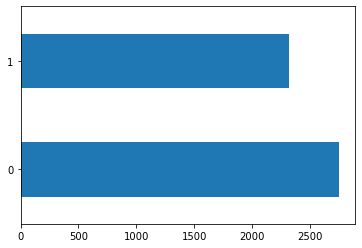

In [13]:
train_df['性别'].value_counts().plot(kind='barh')

<AxesSubplot:xlabel='患有糖尿病标识', ylabel='count'>

C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31958 (\N{CJK UNIFIED IDEOGRAPH-7CD6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23615 (\N{CJK UNIFIED IDEOGRAPH-5C3F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30149 (\

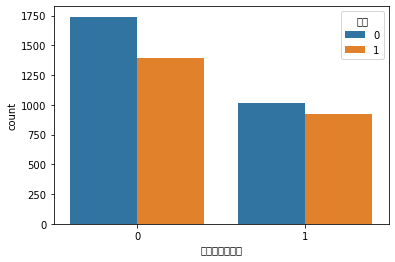

In [14]:
sns.countplot(x='患有糖尿病标识', hue='性别', data=train_df)

<AxesSubplot:xlabel='患有糖尿病标识', ylabel='出生年份'>

C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31958 (\N{CJK UNIFIED IDEOGRAPH-7CD6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23615 (\N{CJK UNIFIED IDEOGRAPH-5C3F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30149 (\

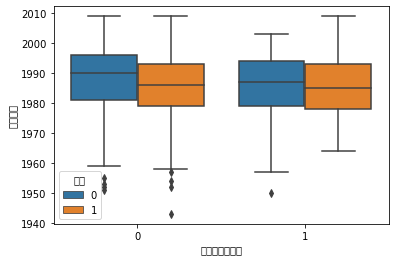

In [15]:
sns.boxplot(y='出生年份', x='患有糖尿病标识', hue='性别', data=train_df)

<AxesSubplot:xlabel='患有糖尿病标识', ylabel='体重指数'>

C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31958 (\N{CJK UNIFIED IDEOGRAPH-7CD6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23615 (\N{CJK UNIFIED IDEOGRAPH-5C3F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30149 (\

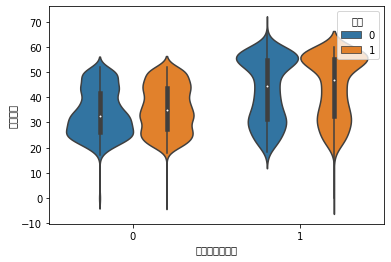

In [16]:
sns.violinplot(y='体重指数', x='患有糖尿病标识', hue='性别', data=train_df)

In [17]:
# 基础思路（0.93分数）
dict_糖尿病家族史 = {
    '无记录': 0,
    '叔叔或姑姑有一方患有糖尿病': 1,
    '叔叔或者姑姑有一方患有糖尿病': 1,
    '父母有一方患有糖尿病': 2
}


In [18]:
train_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识
0,1,0,1996,30.1,无记录,106.0,3.818,7.89,0.0,0
1,2,0,1988,27.5,无记录,84.0,-1.000,0.00,14.7,0
2,3,1,1988,36.5,无记录,85.0,7.131,0.00,40.1,1
3,4,1,1992,29.5,无记录,91.0,7.041,0.00,0.0,0
4,5,0,1998,42.0,叔叔或者姑姑有一方患有糖尿病,NaN,7.134,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
5065,5066,1,1992,36.4,父母有一方患有糖尿病,95.0,3.102,0.00,0.0,0
5066,5067,1,1991,37.1,叔叔或姑姑有一方患有糖尿病,94.0,6.207,6.77,0.0,0
5067,5068,0,1975,25.4,无记录,90.0,7.343,0.00,0.0,0
5068,5069,0,1972,28.5,父母有一方患有糖尿病,101.0,6.268,8.99,0.0,0


In [19]:
test_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度
0,1,0,1987,33.1,无记录,72.0,6.586,24.16,2.94
1,2,0,1998,20.6,叔叔或者姑姑有一方患有糖尿病,68.0,3.861,0.00,0.00
2,3,1,1979,42.1,无记录,98.0,5.713,0.00,3.53
3,4,0,1999,34.6,无记录,66.0,4.684,0.00,3.14
4,5,0,1997,27.7,无记录,89.0,7.948,14.65,2.65
...,...,...,...,...,...,...,...,...,...
995,996,1,1990,50.1,无记录,87.0,5.125,0.00,0.00
996,997,0,1992,56.3,无记录,87.0,7.695,0.00,0.00
997,998,1,1992,23.8,无记录,85.0,3.194,7.50,0.00
998,999,0,2000,53.1,无记录,95.0,8.226,7.55,0.00


In [15]:
train_df['糖尿病家族史'] = train_df['糖尿病家族史'].map(dict_糖尿病家族史)
test_df['糖尿病家族史'] = test_df['糖尿病家族史'].map(dict_糖尿病家族史)

train_df['舒张压'].fillna(89, inplace=True)
test_df['舒张压'].fillna(89, inplace=True)



In [16]:
train_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识
0,1,0,1996,30.1,0,106.0,3.818,7.89,0.0,0
1,2,0,1988,27.5,0,84.0,-1.000,0.00,14.7,0
2,3,1,1988,36.5,0,85.0,7.131,0.00,40.1,1
3,4,1,1992,29.5,0,91.0,7.041,0.00,0.0,0
4,5,0,1998,42.0,1,89.0,7.134,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
5065,5066,1,1992,36.4,2,95.0,3.102,0.00,0.0,0
5066,5067,1,1991,37.1,1,94.0,6.207,6.77,0.0,0
5067,5068,0,1975,25.4,0,90.0,7.343,0.00,0.0,0
5068,5069,0,1972,28.5,2,101.0,6.268,8.99,0.0,0


In [17]:
test_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度
0,1,0,1987,33.1,0,72.0,6.586,24.16,2.94
1,2,0,1998,20.6,1,68.0,3.861,0.00,0.00
2,3,1,1979,42.1,0,98.0,5.713,0.00,3.53
3,4,0,1999,34.6,0,66.0,4.684,0.00,3.14
4,5,0,1997,27.7,0,89.0,7.948,14.65,2.65
...,...,...,...,...,...,...,...,...,...
995,996,1,1990,50.1,0,87.0,5.125,0.00,0.00
996,997,0,1992,56.3,0,87.0,7.695,0.00,0.00
997,998,1,1992,23.8,0,85.0,3.194,7.50,0.00
998,999,0,2000,53.1,0,95.0,8.226,7.55,0.00


In [18]:
# 构建模型
model = make_pipeline(
    MinMaxScaler(),
    DecisionTreeClassifier()
)
model.fit(train_df.drop(['编号', '患有糖尿病标识'], axis=1), train_df['患有糖尿病标识'])

# 模型预测
test_df['label'] = model.predict(test_df.drop(['编号'], axis=1))
test_df.rename({'编号': 'uuid'}, axis=1)[['uuid', 'label']].to_csv('submit.csv', index=None)

In [20]:
# 进阶思路(0.96分数)
# 基础特征工程
train_df['体重指数_round'] = train_df['体重指数'] // 10
test_df['体重指数_round'] = train_df['体重指数'] // 10

train_df['口服耐糖量测试'] = train_df['口服耐糖量测试'].replace(-1, np.nan)
test_df['口服耐糖量测试'] = test_df['口服耐糖量测试'].replace(-1, np.nan)

dict_糖尿病家族史 = {
    '无记录': 0,
    '叔叔或姑姑有一方患有糖尿病': 1,
    '叔叔或者姑姑有一方患有糖尿病': 1,
    '父母有一方患有糖尿病': 2
}

In [21]:
train_df['糖尿病家族史'] = train_df['糖尿病家族史'].map(dict_糖尿病家族史)
test_df['糖尿病家族史'] = test_df['糖尿病家族史'].map(dict_糖尿病家族史)

train_df['糖尿病家族史'] = train_df['糖尿病家族史'].astype('category')
test_df['糖尿病家族史'] = train_df['糖尿病家族史'].astype('category')

train_df['性别'] = train_df['性别'].astype('category')
test_df['性别'] = train_df['性别'].astype('category')

train_df['年龄'] = 2022 - train_df['出生年份']
test_df['年龄'] = 2022 - test_df['出生年份']

In [22]:
train_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识,体重指数_round,年龄
0,1,0,1996,30.1,0,106.0,3.818,7.89,0.0,0,3.0,26
1,2,0,1988,27.5,0,84.0,NaN,0.00,14.7,0,2.0,34
2,3,1,1988,36.5,0,85.0,7.131,0.00,40.1,1,3.0,34
3,4,1,1992,29.5,0,91.0,7.041,0.00,0.0,0,2.0,30
4,5,0,1998,42.0,1,NaN,7.134,0.00,0.0,1,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,5066,1,1992,36.4,2,95.0,3.102,0.00,0.0,0,3.0,30
5066,5067,1,1991,37.1,1,94.0,6.207,6.77,0.0,0,3.0,31
5067,5068,0,1975,25.4,0,90.0,7.343,0.00,0.0,0,2.0,47
5068,5069,0,1972,28.5,2,101.0,6.268,8.99,0.0,0,2.0,50


In [23]:
train_df['口服耐糖量测试_diff'] = train_df['口服耐糖量测试'] - train_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
test_df['口服耐糖量测试_diff'] = test_df['口服耐糖量测试'] - test_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']

C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  """Entry point for launching an IPython kernel.
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  


In [24]:


# 模型交叉验证
def run_model_cv(model, kf, X_tr, y, X_te, cate_col=None):
    train_pred = np.zeros( (len(X_tr), len(np.unique(y))) )
    test_pred = np.zeros( (len(X_te), len(np.unique(y))) )

    cv_clf = []
    for tr_idx, val_idx in kf.split(X_tr, y):
        x_tr = X_tr.iloc[tr_idx]; y_tr = y.iloc[tr_idx]

        x_val = X_tr.iloc[val_idx]; y_val = y.iloc[val_idx]

        call_back = [
            lgb.early_stopping(50),
        ]
        eval_set = [(x_val, y_val)]
        model.fit(x_tr, y_tr, eval_set=eval_set, callbacks=call_back, verbose=-1)

        cv_clf.append(model)

        train_pred[val_idx] = model.predict_proba(x_val)
        test_pred += model.predict_proba(X_te)

    test_pred /= kf.n_splits
    return train_pred, test_pred, cv_clf

clf = lgb.LGBMClassifier(
    max_depth=3, 
    n_estimators=4000, 
    n_jobs=-1, 
    verbose=-1,
    verbosity=-1,
    learning_rate=0.1,
)

train_pred, test_pred, cv_clf = run_model_cv(
    clf, KFold(n_splits=5),
    train_df.drop(['编号', '患有糖尿病标识'], axis=1),
    train_df['患有糖尿病标识'],
    test_df.drop(['编号'], axis=1),
)

print((train_pred.argmax(1) == train_df['患有糖尿病标识']).mean())
test_df['label'] = test_pred.argmax(1)
test_df.rename({'编号': 'uuid'}, axis=1)[['uuid', 'label']].to_csv('submit.csv', index=None)

C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.1346
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1


C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\New

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.119175
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.115571
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds


C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.13425
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds


C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\New Project\1_Anaconda3\envs\pytorch1.9\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.10254
0.9554240631163708


In [25]:
train_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识,体重指数_round,年龄,口服耐糖量测试_diff
0,1,0,1996,30.1,0,106.0,3.818,7.89,0.0,0,3.0,26,-2.078475
1,2,0,1988,27.5,0,84.0,NaN,0.00,14.7,0,2.0,34,NaN
2,3,1,1988,36.5,0,85.0,7.131,0.00,40.1,1,3.0,34,1.234525
3,4,1,1992,29.5,0,91.0,7.041,0.00,0.0,0,2.0,30,1.144525
4,5,0,1998,42.0,1,NaN,7.134,0.00,0.0,1,4.0,24,1.166788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,5066,1,1992,36.4,2,95.0,3.102,0.00,0.0,0,3.0,30,-3.023952
5066,5067,1,1991,37.1,1,94.0,6.207,6.77,0.0,0,3.0,31,0.239788
5067,5068,0,1975,25.4,0,90.0,7.343,0.00,0.0,0,2.0,47,1.446525
5068,5069,0,1972,28.5,2,101.0,6.268,8.99,0.0,0,2.0,50,0.142048


In [27]:
#安装相关依赖库 如果是windows系统，cmd命令框中输入pip安装，参考上述环境配置
#!pip install sklearn
#!pip install pandas
#---------------------------------------------------
#导入库
#----------------数据探索----------------
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
#数据预处理
data1=pd.read_csv('./糖尿病遗传风险预测挑战赛公开数据/比赛训练集.csv', encoding='utf-8')
data2=pd.read_csv('./糖尿病遗传风险预测挑战赛公开数据/比赛测试集.csv', encoding='utf-8')
#label标记为-1
data2['患有糖尿病标识']=-1
#训练集和测试机合并
data=pd.concat([data1,data2],axis=0,ignore_index=True)
#将舒张压特征中的缺失值填充为-1
data['舒张压']=data['舒张压'].fillna(-1)

#----------------特征工程----------------
"""
将出生年份换算成年龄
"""
data['年龄']=2022-data['出生年份']  #换成年龄


"""
人体的成人体重指数正常值是在18.5-24之间
低于18.5是体重指数过轻
在24-27之间是体重超重
27以上考虑是肥胖
高于32了就是非常的肥胖。
"""
def BMI(a):
    if a<18.5:
        return 0
    elif 18.5<=a<=24:
        return 1
    elif 24<a<=27:
        return 2
    elif 27<a<=32:
        return 3
    else:
        return 4

data['BMI']=data['体重指数'].apply(BMI)

#糖尿病家族史
"""
无记录
叔叔或者姑姑有一方患有糖尿病/叔叔或姑姑有一方患有糖尿病
父母有一方患有糖尿病
"""
def FHOD(a):
    if a=='无记录':
        return 0
    elif a=='叔叔或者姑姑有一方患有糖尿病' or a=='叔叔或姑姑有一方患有糖尿病':
        return 1
    else:
        return 2


data['糖尿病家族史']=data['糖尿病家族史'].apply(FHOD)
"""
舒张压范围为60-90
"""
def DBP(a):
    if a<60:
        return 0
    elif 60<=a<=90:
        return 1
    elif a>90:
        return 2
    else:
        return a
data['DBP']=data['舒张压'].apply(DBP)


#------------------------------------
#将处理好的特征工程分为训练集和测试集，其中训练集是用来训练模型，测试集用来评估模型准确度
#其中编号和患者是否得糖尿病没有任何联系，属于无关特征予以删除
train=data[data['患有糖尿病标识'] !=-1]
test=data[data['患有糖尿病标识'] ==-1]
train_label=train['患有糖尿病标识']
train=train.drop(['编号','患有糖尿病标识','出生年份'],axis=1)
test=test.drop(['编号','患有糖尿病标识','出生年份'],axis=1)

#----------------模型训练----------------
model = DecisionTreeClassifier()
model.fit(train, train_label) 
y_pre=model.predict(test)
y_pre

#----------------结果输出----------------
result=pd.read_csv('./糖尿病遗传风险预测挑战赛公开数据/提交示例.csv')
result['label']=y_pre
result.to_csv('result-de.csv',index=False)